In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%matplotlib inline

In [54]:
df = pd.read_csv('./ENX.PA.csv', header=0, index_col=0)
df = df.drop(['Volume','Adj Close'], axis=1)
df.head()

Open       High        Low      Close
Date                                                  
2015-06-09  37.160000  37.160000  36.064999  36.540001
2015-06-10  36.299999  36.549999  36.000000  36.509998
2015-06-11  36.695000  37.740002  36.650002  37.330002
2015-06-12  37.099998  37.185001  35.680000  35.939999
2015-06-15  35.605000  35.605000  35.400002  35.500000

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2096 entries, 2015-06-09 to 2023-08-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2094 non-null   float64
 1   High    2094 non-null   float64
 2   Low     2094 non-null   float64
 3   Close   2094 non-null   float64
dtypes: float64(4)
memory usage: 81.9+ KB


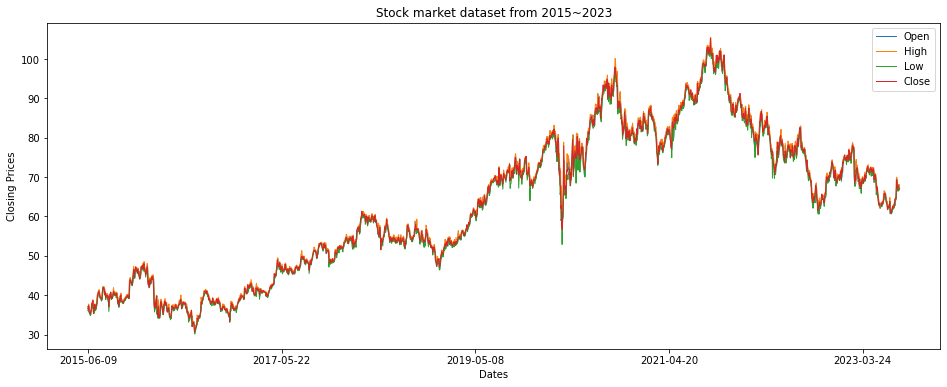

In [56]:
df.plot(figsize=(16,6),lw=1)
plt.title('Stock market dataset from 2015~2023')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

In [35]:
df_ENX = pd.read_csv('./ENX.csv', header=0, index_col=0)
df_ENX.head()

Close  Volume  EMA10  EMA50  EMA100  ROC12  ROC24 Name   AUD   CAD  \
Date                                                                            
6/9/2015   28.95  140255    NaN    NaN     NaN    NaN    NaN  ENX  1.30  1.24   
6/10/2015  28.92  245288    NaN    NaN     NaN    NaN    NaN  ENX  1.30  1.23   
6/11/2015  29.57  134151    NaN    NaN     NaN    NaN    NaN  ENX  1.29  1.23   
6/12/2015  28.47   90877    NaN    NaN     NaN    NaN    NaN  ENX  1.29  1.23   
6/15/2015  28.12   89958    NaN    NaN     NaN    NaN    NaN  ENX  1.29  1.23   

           ...    USD     JPY  JPXGY   NASDAQ    NIKKEI      NYSE      SSE  \
Date       ...                                                               
6/9/2015   ...  95.17  124.56   7.65  5013.87  20096.30  10915.64  5113.53   
6/10/2015  ...  94.65  124.34   7.40  5076.69  20046.36  11057.99  5106.04   
6/11/2015  ...  94.98  122.87   7.45  5082.51  20382.97  11080.51  5121.59   
6/12/2015  ...  94.97  123.58   7.42  5051.10  20407.08  11009.91  5166.35   
6/15/2015  ...  94.81  123.29   7.56  5029.97  20387.79  10949.54  5062.99   

             GOLD    OIL  SILVER  
Date                              
6/9/2015   1177.6  60.14   15.96  
6/10/2015  1186.6  61.43   15.96  
6/11/2015  1180.4  60.77   15.96  
6/12/2015  1179.2  59.96   15.83  
6/15/2015  1185.8  59.52   16.08  

[5 rows x 22 columns]

In [4]:
residuals = pd.read_csv('./ENX_residuals.csv', header=0, index_col=0)
residuals.head()

Residual
Date               
6/9/2015   0.000000
6/10/2015 -2.747231
6/11/2015  0.649389
6/12/2015 -1.086753
6/15/2015 -0.372565

In [7]:
# Combine with ARIMA residuals
df_ENX = pd.concat([df_ENX, residuals], axis=1)
df_ENX

Close  Volume      EMA10      EMA50     EMA100     ROC12  \
Date                                                                  
6/9/2015   28.95  140255        NaN        NaN        NaN       NaN   
6/10/2015  28.92  245288        NaN        NaN        NaN       NaN   
6/11/2015  29.57  134151        NaN        NaN        NaN       NaN   
6/12/2015  28.47   90877        NaN        NaN        NaN       NaN   
6/15/2015  28.12   89958        NaN        NaN        NaN       NaN   
...          ...     ...        ...        ...        ...       ...   
8/3/2023   67.35  182735  66.300098  64.818163  65.822441 -7.572383   
8/4/2023   67.80  178270  66.572808  64.935098  65.861601 -6.858407   
8/8/2023   66.80  125888  66.614115  65.008231  65.880183 -5.838323   
8/9/2023   67.05   74043  66.693367  65.088301  65.903348 -3.952274   
8/10/2023  68.00   88604  66.930937  65.202485  65.944866 -5.073529   

               ROC24 Name   AUD   CAD  ...     JPY  JPXGY    NASDAQ    NIKKEI  \
Date                                   ...                                      
6/9/2015         NaN  ENX  1.30  1.24  ...  124.56   7.65   5013.87  20096.30   
6/10/2015        NaN  ENX  1.30  1.23  ...  124.34   7.40   5076.69  20046.36   
6/11/2015        NaN  ENX  1.29  1.23  ...  122.87   7.45   5082.51  20382.97   
6/12/2015        NaN  ENX  1.29  1.23  ...  123.58   7.42   5051.10  20407.08   
6/15/2015        NaN  ENX  1.29  1.23  ...  123.29   7.56   5029.97  20387.79   
...              ...  ...   ...   ...  ...     ...    ...       ...       ...   
8/3/2023   -7.201188  ENX  1.53  1.33  ...  143.34   8.68  13959.72  32159.28   
8/4/2023   -8.112094  ENX  1.52  1.34  ...  142.60   8.68  13909.24  32192.75   
8/8/2023   -6.362275  ENX  1.52  1.34  ...  142.52   9.02  13884.32  32377.29   
8/9/2023   -4.772558  ENX  1.53  1.34  ...  143.28   8.93  13722.02  32204.33   
8/10/2023 -10.220588  ENX  1.53  1.34  ...  143.73   9.03  13737.99  32473.65   

               NYSE      SSE    GOLD    OIL  SILVER  Residual  
Date                                                           
6/9/2015   10915.64  5113.53  1177.6  60.14   15.96  0.000000  
6/10/2015  11057.99  5106.04  1186.6  61.43   15.96 -2.747231  
6/11/2015  11080.51  5121.59  1180.4  60.77   15.96  0.649389  
6/12/2015  11009.91  5166.35  1179.2  59.96   15.83 -1.086753  
6/15/2015  10949.54  5062.99  1185.8  59.52   16.08 -0.372565  
...             ...      ...     ...    ...     ...       ...  
8/3/2023   16125.42  3280.46  1932.0  81.55   23.70  0.193007  
8/4/2023   16071.06  3288.08  1939.6  82.82   23.72  0.454664  
8/8/2023   16176.35  3260.62  1959.9  82.92   22.81 -0.989512  
8/9/2023   16135.77  3244.49  1950.6  84.40   22.73  0.226632  
8/10/2023  16135.22  3254.56  1948.9  82.82   22.82  0.955850  

[1787 rows x 23 columns]

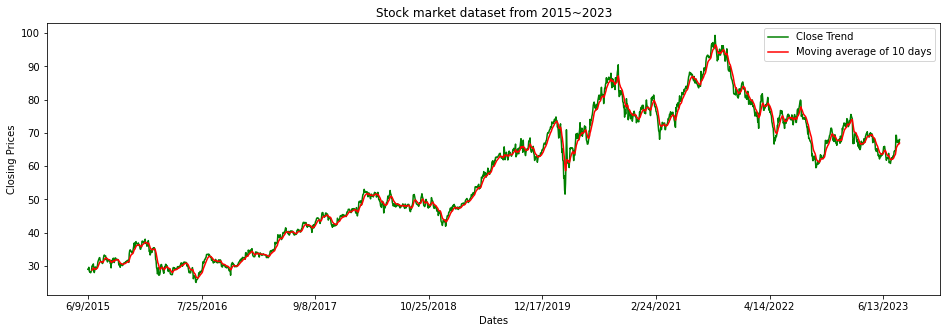

In [59]:
plt.figure(figsize=(16,5))
plt.grid(True)
df_ENX["Close"].plot(color='green', label='Close Trend')
df_ENX["EMA10"].plot(color='red', label='Moving average of 10 days')
plt.title('Stock market dataset from 2015~2023')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.legend()
# df_ENX["Residual"].plot()
plt.show()

In [58]:
df_ENX.describe()

Close        Volume        EMA10        EMA50       EMA100  \
count  1787.000000  1.787000e+03  1778.000000  1738.000000  1688.000000   
mean     56.886514  1.345525e+05    56.932425    57.139514    57.375307   
std      19.114732  1.587883e+05    19.040523    18.817623    18.560584   
min      25.010000  9.589000e+03    26.340071    28.233096    29.219742   
25%      40.160000  8.438750e+04    40.168297    40.692722    41.295168   
50%      59.510000  1.134000e+05    60.187404    60.458258    59.832583   
75%      73.175000  1.551485e+05    73.250157    74.485513    75.477946   
max      99.340000  5.254711e+06    96.542460    92.888184    89.802120   

             ROC12        ROC24          AUD          CAD          EUR  ...  \
count  1776.000000  1764.000000  1787.000000  1787.000000  1787.000000  ...   
mean     -0.371139    -0.715127     1.385490     1.308808     1.126010  ...   
std       5.597650     8.072321     0.078911     0.042187     0.054208  ...   
min     -21.194988   -25.119760     1.230000     1.200000     0.960000  ...   
25%      -4.060477    -6.314839     1.320000     1.280000     1.090000  ...   
50%      -0.822718    -1.268218     1.380000     1.310000     1.120000  ...   
75%       2.666626     3.663957     1.440000     1.330000     1.170000  ...   
max      39.499709    43.746364     1.740000     1.460000     1.250000  ...   

               USD          JPY        JPXGY        NASDAQ        NIKKEI  \
count  1787.000000  1787.000000  1787.000000   1787.000000   1787.000000   
mean     97.119306   115.025434     8.910369   9004.687778  23094.139155   
std       4.554272    10.790262     1.764288   3324.423894   4245.679887   
min      88.670000    99.910000     5.450000   4363.140000  14952.020000   
25%      93.940000   108.475000     7.665000   6209.055000  19909.380000   
50%      96.670000   111.120000     8.500000   7953.880000  22396.990000   
75%      99.265000   118.160000     9.450000  11831.700000  27231.175000   
max     114.110000   150.180000    14.160000  16057.440000  33753.330000   

               NYSE          SSE         GOLD          OIL       SILVER  
count   1787.000000  1787.000000  1787.000000  1787.000000  1787.000000  
mean   13140.700050  3188.615422  1512.347398    59.843570    19.143587  
std     2109.599626   311.695511   291.860156    18.441608     4.030931  
min     8777.380000  2483.090000  1049.600000   -37.630000    11.770000  
25%    11505.255000  2977.445000  1258.050000    47.090000    15.980000  
50%    12766.650000  3198.840000  1400.500000    56.870000    17.590000  
75%    15081.255000  3370.410000  1803.900000    70.590000    23.100000  
max    17353.760000  5166.350000  2069.400000   123.700000    29.420000  

[8 rows x 21 columns]

In [80]:
# Convert index to datetime64
df_ENX.index = pd.to_datetime(df_ENX.index)
start = df_ENX.index.min()
end = df_ENX.index.max()
print('Start date: ', start)
print('End date: ', end)

Start date:  2015-06-09 00:00:00
End date:  2023-08-10 00:00:00


<class 'pandas.core.series.Series'>
DatetimeIndex: 1787 entries, 2015-06-09 to 2023-08-10
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1787 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


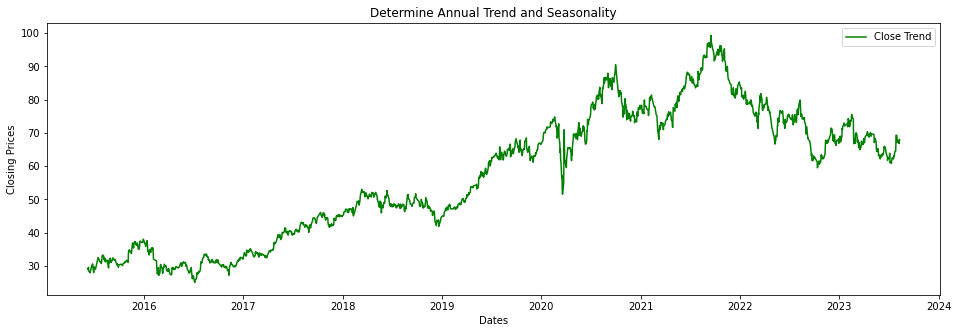

In [82]:
# Select close column for fitting the model
df_close = df_ENX["Close"]
df_close.info()

# Observe Close dataset
plt.figure(figsize=(16,5))
# plt.grid(True)
plt.tight_layout()
plt.title('Determine Annual Trend and Seasonality')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Close Trend')
plt.legend()
plt.show()

In [64]:
# Check index data type of datetime64
print(type(df_close.index))
print(df_close.index.inferred_type == "datetime64")
df_close.dropna(inplace=True)
df_close.head()

<class 'pandas.core.indexes.base.Index'>
False


Date
6/9/2015     28.95
6/10/2015    28.92
6/11/2015    29.57
6/12/2015    28.47
6/15/2015    28.12
Name: Close, dtype: float64

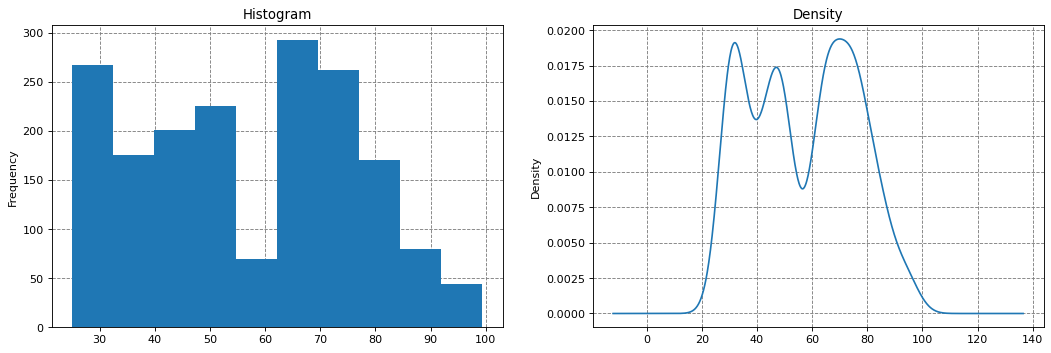

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
df_close.plot(title='Histogram', kind='hist', ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')
df_close.plot(title='Density', kind='kde', ax=ax2)
ax2.grid(color='gray', linestyle='dashed')
plt.show()

In [113]:
df_close.skew() 

0.05179087773297612

In [66]:
# Split the data for train and test
row_len = int(len(df_close)*0.8)
df_train = list(df_close[0:row_len].copy())
df_test = list(df_close[row_len:].copy())

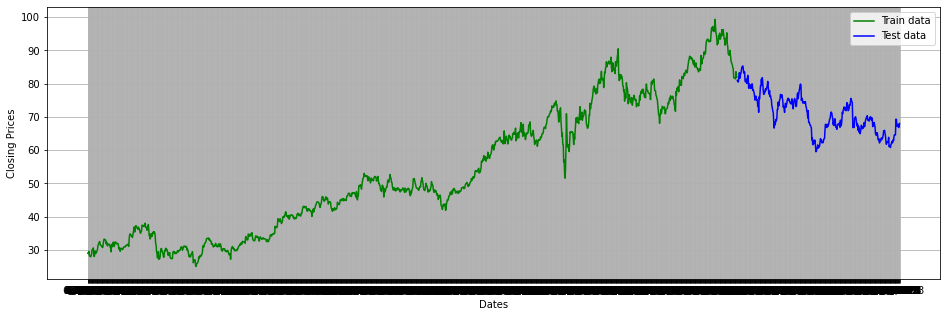

In [67]:
# Plot training and testing data
plt.figure(figsize=(16,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close[0:row_len], 'green', label='Train data')
plt.plot(df_close[row_len:], 'blue', label='Test data')
plt.legend()
plt.show()

In [68]:
# Perform differencing
def to_stationary(df):
    cycle = 0
    df_diff = df.diff().dropna()
    cycle += 1
    if df_diff[1] <= 0.05:
        print(f"p.value: {df_diff[1]}")
        print(f"Cycle of differencing: {cycle}")
        return df_diff
    else:
        return to_stationary(df_diff)

p.value: -1.75
Cycle of differencing: 1


<AxesSubplot:title={'center':'Close Trend After Differencing'}, xlabel='Date'>

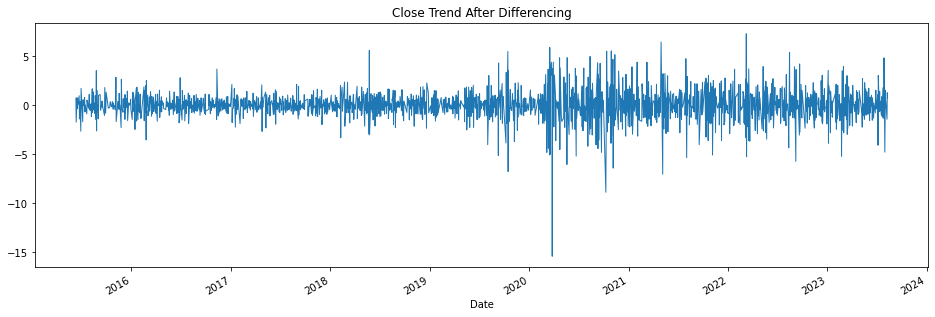

In [84]:
df_ts_diff = to_stationary(df_close)
df_ts_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")

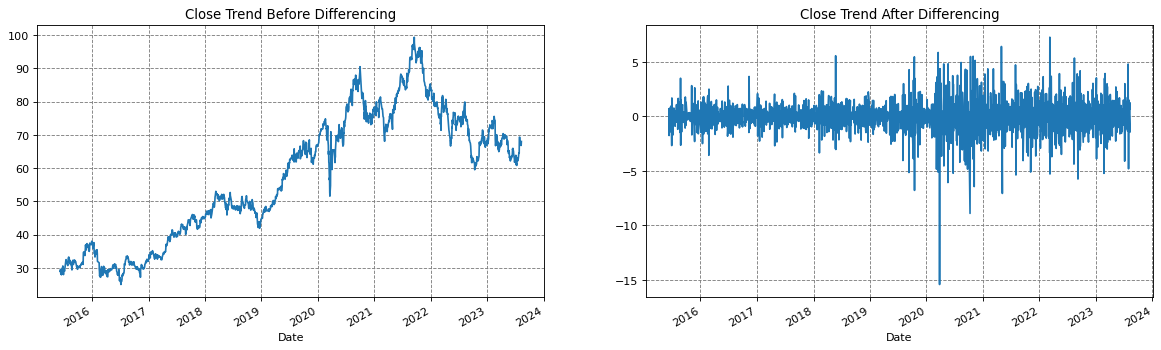

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
df_close.plot(title='Close Trend Before Differencing', ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')
df_ts_diff.plot(title='Close Trend After Differencing', ax=ax2)
ax2.grid(color='gray', linestyle='dashed')
plt.show()

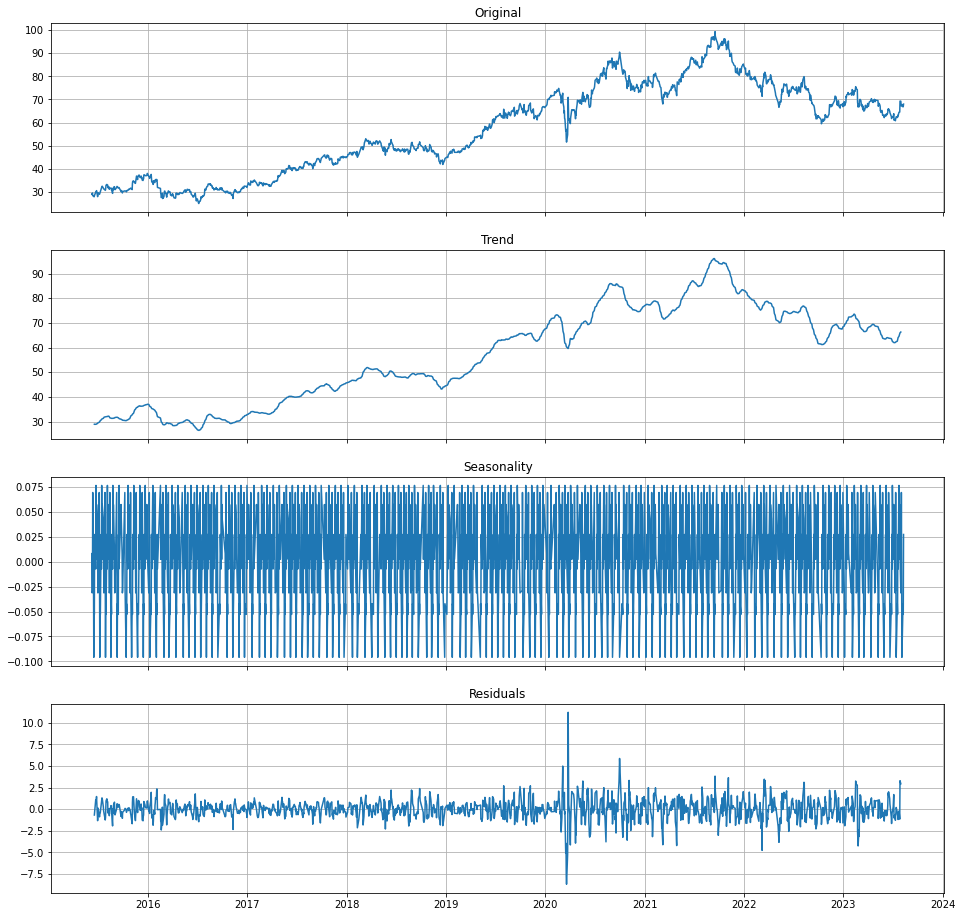

In [94]:
def decompose_ts(df, period):
    decomposition = smt.seasonal_decompose(df, period=period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid   
    fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False, figsize=(16,16))
    ax[0].plot(df)
    ax[0].set_title('Original')
    ax[0].grid(True) 
    ax[1].plot(trend)
    ax[1].set_title('Trend')
    ax[1].grid(True)  
    ax[2].plot(seasonal)
    ax[2].set_title('Seasonality')
    ax[2].grid(True)  
    ax[3].plot(residual)
    ax[3].set_title('Residuals')
    ax[3].grid(True)
    
decompose_ts(df_close,14)

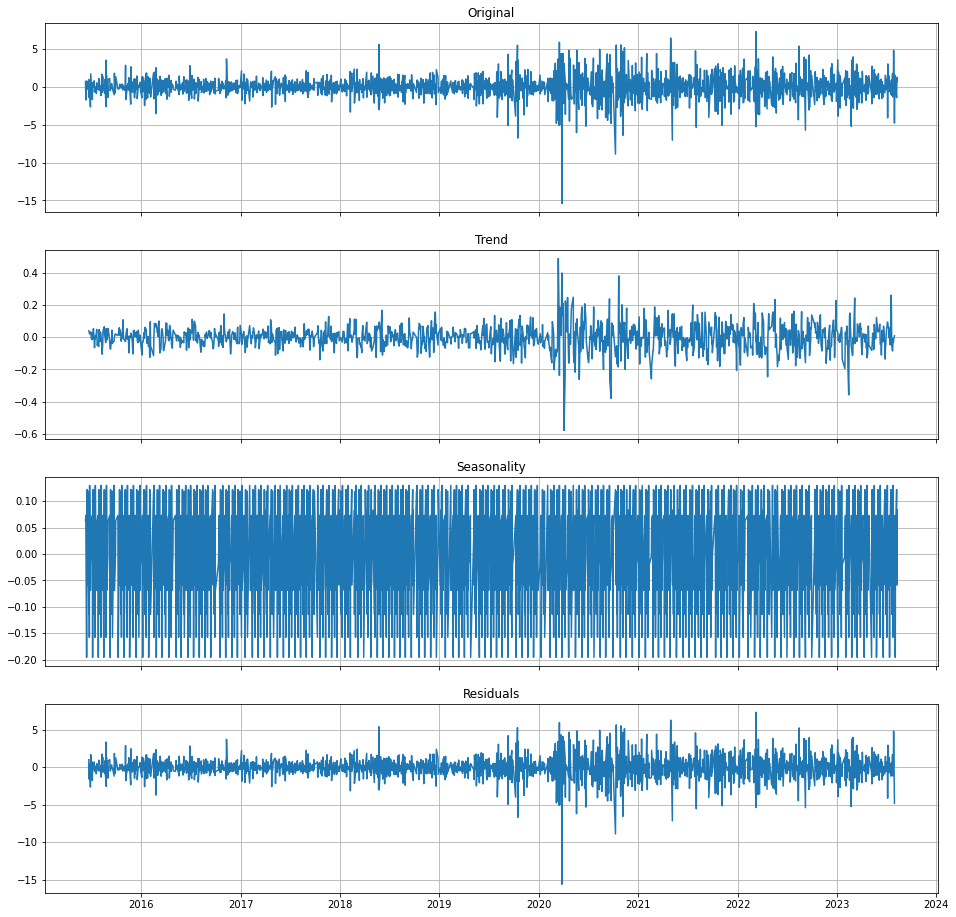

In [97]:
decompose_ts(df_ts_diff,14)

In [120]:
# Creating function to display ACF and PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation ACF')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation PACF')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

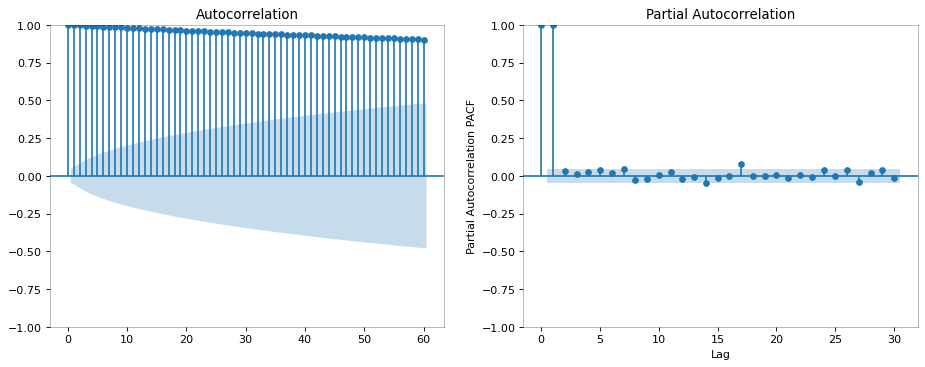

In [119]:
plot_correlation(df_close)

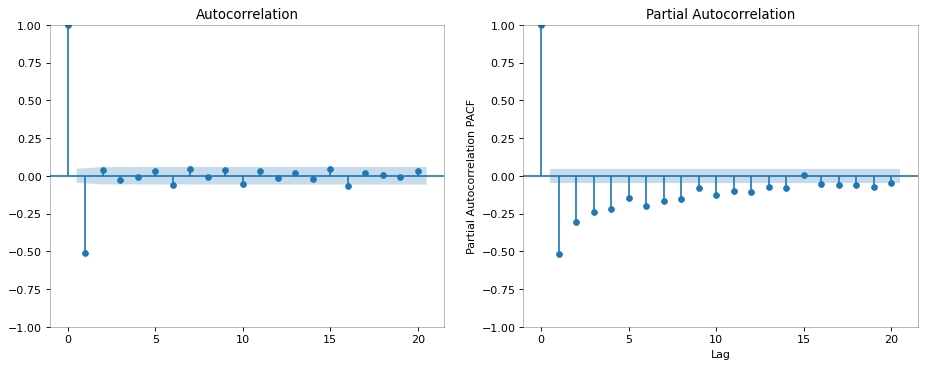

In [121]:
plot_correlation(df_ts_diff)

In [109]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [110]:
ADF(df_ts_diff)

Column Name: Close Variable
ADF Statistic: -14.603439
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## Determine parameters

In [112]:
# library that determine best parameters for ARIMA model
import pmdarima as pm
from pmdarima import auto_arima

In [113]:
model = auto_arima(df_train, start_p=0, start_q=0,
                          max_p=5, max_q=5,m=12,start_P=0,start_Q=0, 
                          max_P = 5, max_Q = 5,
                          seasonal=False,
                          d=1,D=1,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4153.854, Time=1.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4155.121, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4155.087, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4153.692, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4149.888, Time=0.97 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4150.079, Time=1.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4150.342, Time=0.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4156.162, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4156.504, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4157.157, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4150.661, Time=0.33 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 6.583 seconds


In [135]:
# Function that extract model train according to given length
residuals = []
def model_fit(length):
    model_predictions = []
    
    for i in range(length):
        model = ARIMA(df_train, order=(1,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        residuals.append(df_train[i] - yhat)
        model_predictions.append(yhat)
        actual_test_value = df_test[i]
        df_train.append(actual_test_value)

    print(len(model_predictions))
    print(model_fit.summary())
    
    return model_predictions

********************************************************************************

## Train Model Residuals

In [136]:
# Function that extract model train according to given length
train_residuals = []
def model_fit_train(length):
    model_predictions = []
    
    for i in range(length):
        model = ARIMA(df_train, order=(1,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        train_residuals.append(df_train[i] - yhat)
        model_predictions.append(yhat)
        actual_test_value = df_train[i]
        df_train.append(actual_test_value)

    print(len(model_predictions))
    print(model_fit.summary())
    
    return model_predictions

In [139]:
# For model prediction for whole train set
n_train_observ = len(df_train)
model_train_predictionn = model_fit_train(n_train_observ)

1797
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3593
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6408.719
Date:                Tue, 19 Sep 2023   AIC                          12821.438
Time:                        16:33:04   BIC                          12833.810
Sample:                             0   HQIC                         12825.847
                               - 3593                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0217      0.013     -1.717      0.086      -0.046       0.003
sigma2         2.0760      0.003    705.663      0.000       2.070       2.082
Ljung-Box (L1) (Q):                   0.00   Ja

In [149]:
# pd.Series(sorted(date_range_1.union(date_range_2)))
train_ind = df_close.index
train_ind = train_ind.union(new_date)
train_ind

DatetimeIndex(['2015-06-09', '2015-06-10', '2015-06-11', '2015-06-12',
               '2015-06-15', '2015-06-16', '2015-06-17', '2015-06-18',
               '2015-06-19', '2015-06-23',
               ...
               '2023-08-11', '2023-08-14', '2023-08-15', '2023-08-16',
               '2023-08-17', '2023-08-18', '2023-08-21', '2023-08-22',
               '2023-08-23', '2023-08-24'],
              dtype='datetime64[ns]', length=1797, freq=None)

In [150]:
# Create dataframe for residuals
train_residuals = pd.DataFrame(train_residuals, columns=['Residual'])
train_residuals.index = train_ind
train_residuals.head()

Residual
2015-06-09 -55.175724
2015-06-10  -2.747231
2015-06-11   0.649389
2015-06-12  -1.086753
2015-06-15  -0.372565

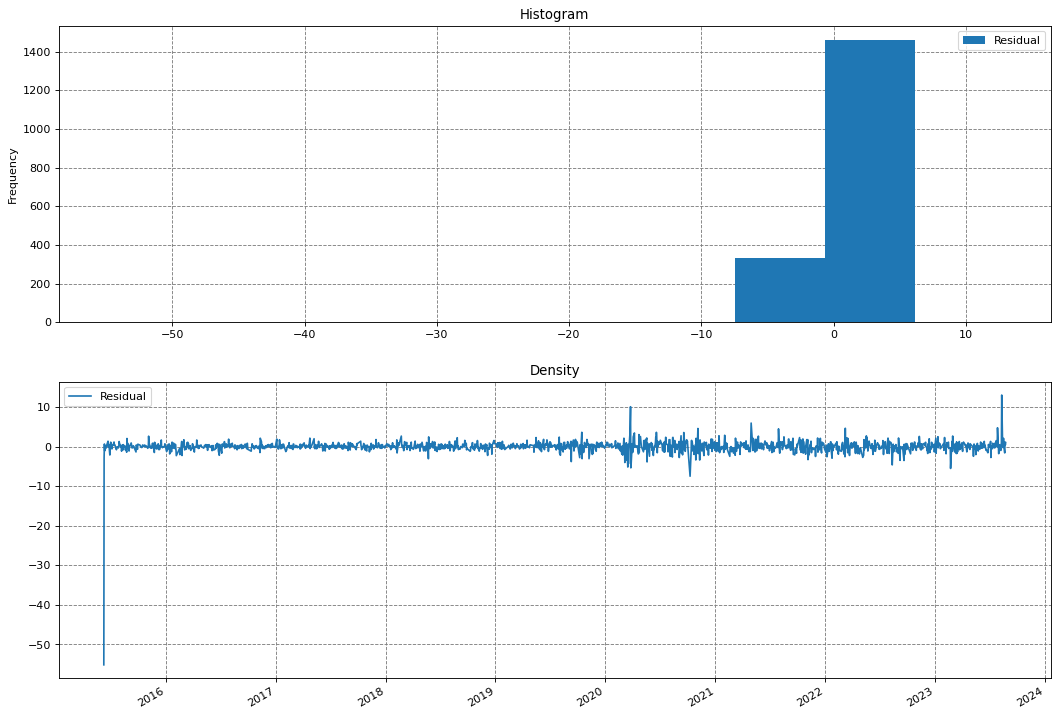

In [151]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12), dpi=80)
train_residuals.plot(title='Histogram', kind='hist', ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')
train_residuals.plot(title='Density', kind='line', ax=ax2)
ax2.grid(color='gray', linestyle='dashed')
plt.show()

In [153]:
train_residuals.to_csv('./train_residuals2.csv')

**************************

## Model Summary

In [137]:
# For model prediction for whole train set
n_test_observ = len(df_test)
model_prediction = model_fit(n_test_observ)

358
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1786
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2645.725
Date:                Tue, 19 Sep 2023   AIC                           5295.450
Time:                        16:29:58   BIC                           5306.424
Sample:                             0   HQIC                          5299.503
                               - 1786                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0312      0.011     -2.724      0.006      -0.054      -0.009
sigma2         1.1349      0.017     68.180      0.000       1.102       1.167
Ljung-Box (L1) (Q):                   0.00   Jar

In [138]:
# For extended prediction using previous model prediction
extend_predict = model_fit(10)

10
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1796
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2731.600
Date:                Tue, 19 Sep 2023   AIC                           5467.199
Time:                        16:29:59   BIC                           5478.185
Sample:                             0   HQIC                          5471.255
                               - 1796                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0247      0.012     -2.018      0.044      -0.049      -0.001
sigma2         1.2284      0.013     91.069      0.000       1.202       1.255
Ljung-Box (L1) (Q):                   0.00   Jarq

In [74]:
# Insert NAN at the beginning of new_predict dataset
for i in range(len(df_test)):
    extend_predict.insert(0, np.nan)
len(extend_predict)

368

In [75]:
# Adding NAN at the end of df_test and df_predictions
new_df_test = df_test
df_predictions = model_prediction
for i in range(10):
    new_df_test.append(np.nan)
    df_predictions.append(np.nan)
print(len(new_df_test))
print(len(df_predictions))

368
368


In [76]:
max_date = max(df_close[row_len:].index)

In [147]:
# Get date index of df_test using df_close
date_range = df_close[row_len:].index
# add 10 periods of date time array for 10 extended prediction
added_date = pd.date_range(max_date, periods=11, freq='B') 
# Combine two date range
new_date = date_range.union(added_date)
new_date

DatetimeIndex(['2021-12-10', '2021-12-13', '2021-12-14', '2021-12-15',
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23',
               ...
               '2023-08-11', '2023-08-14', '2023-08-15', '2023-08-16',
               '2023-08-17', '2023-08-18', '2023-08-21', '2023-08-22',
               '2023-08-23', '2023-08-24'],
              dtype='datetime64[ns]', length=368, freq=None)

In [78]:
# Create dataframe for df_test and df_predictions
# pd.DataFrame(q_list, columns=['q_data'])
new_df_test = pd.DataFrame(new_df_test, columns=['Actual'])
new_df_test.index = new_date
df_predictions = pd.DataFrame(df_predictions, columns=['Predicted'])
df_predictions.index = new_date
extend_predict = pd.DataFrame(extend_predict, columns=['Extended'])
extend_predict.index = new_date

print(len(new_df_test))
print(len(df_predictions))
print(len(extend_predict))

368
368
368


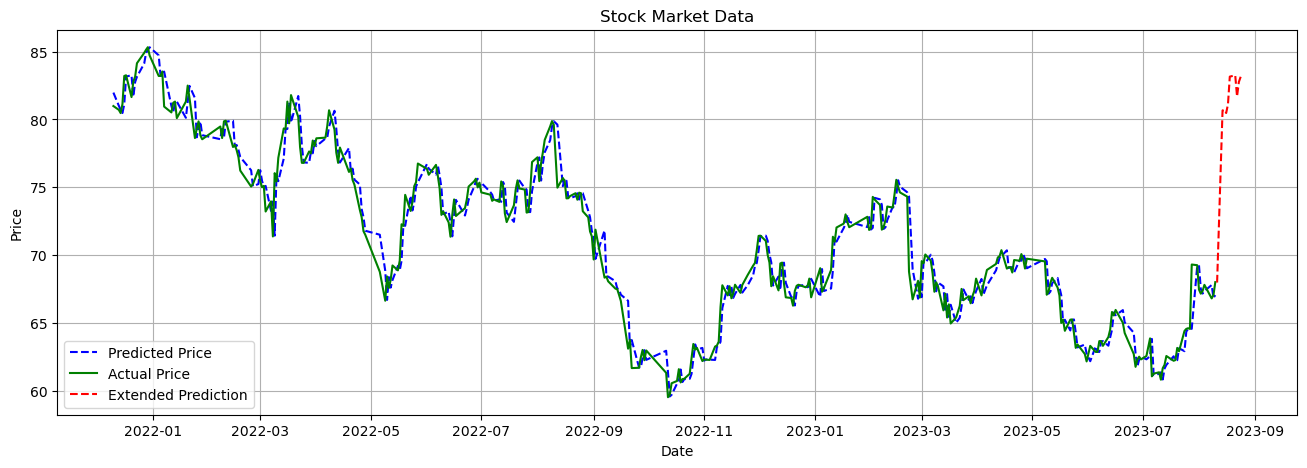

In [79]:
# Finally plotting all the dataset
plt.figure(figsize=(16,5))
plt.grid(True)
plt.plot(df_predictions, color = 'blue', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(new_df_test, color = 'green', label = 'Actual Price')
plt.plot(extend_predict, color = 'red', linestyle = 'dashed', label = 'Extended Prediction')
plt.title('Stock Market Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [120]:
# Create dataframe for residuals
residuals = pd.DataFrame(residuals, columns=['Residual'])
residuals.index = new_date
residuals.head()

ValueError: Length mismatch: Expected axis has 358 elements, new values have 368 elements

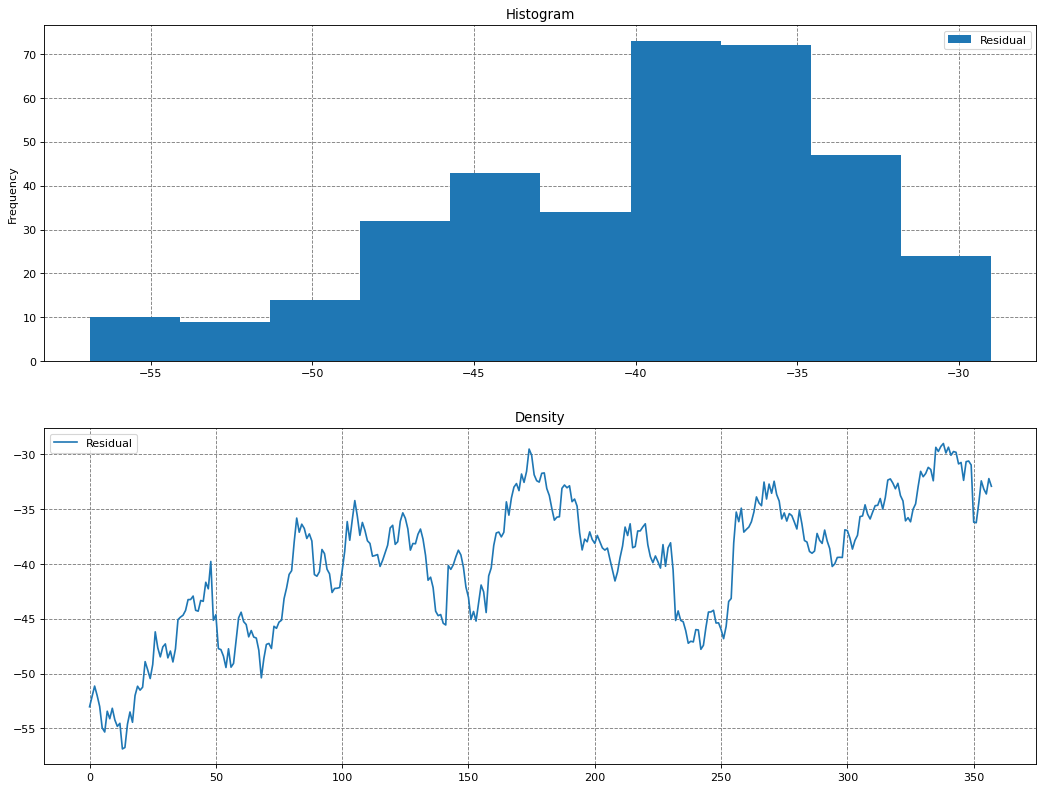

In [121]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12), dpi=80)
residuals.plot(title='Histogram', kind='hist', ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')
residuals.plot(title='Density', kind='line', ax=ax2)
ax2.grid(color='gray', linestyle='dashed')
plt.show()

# residuals.plot(kind='hist')
# plt.grid(True)
# # plt.plot(residuals, color = 'orange', linestyle = 'dashed', label = 'Residual')
# plt.title('Model Residual')
# plt.xlabel('Date')
# plt.ylabel('Difference')
# plt.legend()
# plt.show()

In [82]:
residuals.to_csv('./residuals2.csv')

In [104]:
# df_merged = df1.append(df2, ignore_index=True)
all_residuals = train_residuals.append(residuals)
all_residuals

Residual
2015-06-09 -31.680352
2015-06-10  -0.469664
2015-06-11   0.649741
2015-06-12  -1.094394
2015-06-15  -0.359764
...               ...
2023-08-18 -54.950013
2023-08-21 -55.338797
2023-08-22 -53.448787
2023-08-23 -54.121620
2023-08-24 -53.170865

[1976 rows x 1 columns]

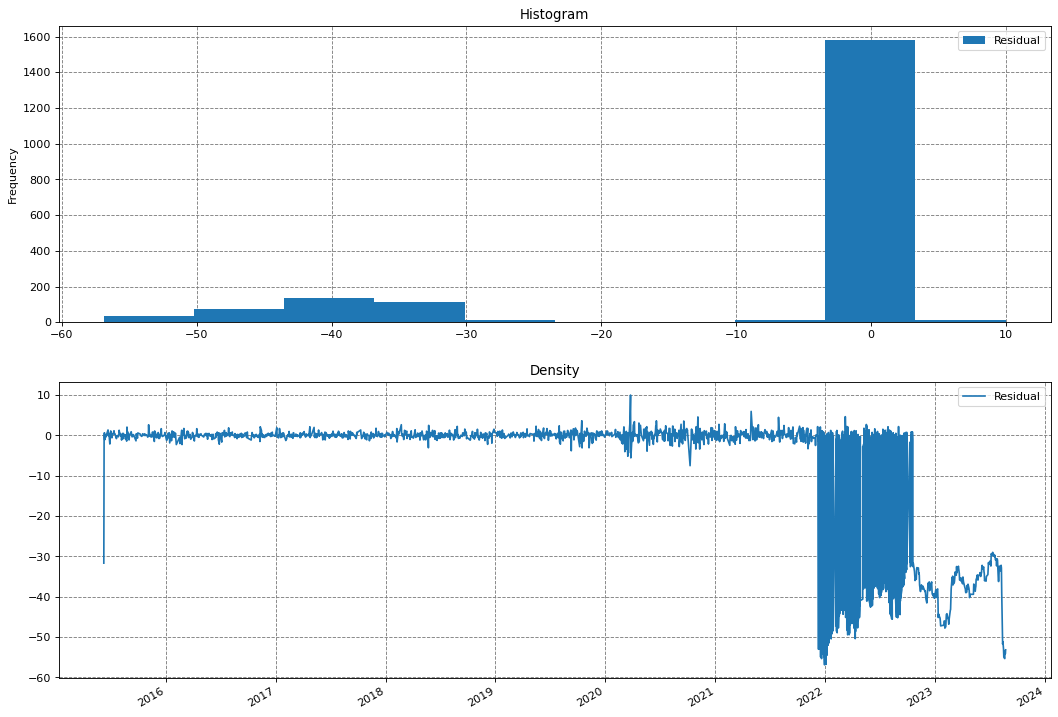

In [105]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12), dpi=80)
all_residuals.plot(title='Histogram', kind='hist', ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')
all_residuals.plot(title='Density', kind='line', ax=ax2)
ax2.grid(color='gray', linestyle='dashed')
plt.show()

## Performance evaluation

In [32]:
# Calculate Mean Absolute Percentage Error using the created dataframes
mape = np.mean(np.abs(np.array(df_predictions) - np.array(new_df_test))/np.abs(new_df_test))
print(f'MAPE: ', mape)

MAPE:  Actual    0.011544
dtype: float64


In [33]:
df_test = df_test.dropna()
df_test

AttributeError: 'list' object has no attribute 'dropna'

In [ ]:
# Calculate Mean squared error for the list of expected and predicted value
mse = mean_squared_error(df_test, model_prediction)
print('MSE: %f' % mse)

In [85]:
# Get root mean squared error
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

NameError: name 'mse' is not defined